In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/projet-4/dataCleanP4.csv
/kaggle/input/projet-4/yearbuilt.png
/kaggle/input/projet-4/__results__.html
/kaggle/input/projet-4/Corr1.png
/kaggle/input/projet-4/electricityratio.png
/kaggle/input/projet-4/Estar.png
/kaggle/input/projet-4/Corr2.png
/kaggle/input/projet-4/steamratio.png
/kaggle/input/projet-4/__notebook__.ipynb
/kaggle/input/projet-4/gasratio.png
/kaggle/input/projet-4/__output__.json
/kaggle/input/projet-4/compacity.png
/kaggle/input/projet-4/custom.css
/kaggle/input/projet-4/__results___files/__results___65_0.png
/kaggle/input/projet-4/__results___files/__results___72_1.png
/kaggle/input/projet-4/__results___files/__results___67_0.png
/kaggle/input/projet-4/__results___files/__results___66_0.png
/kaggle/input/projet-4/__results___files/__results___59_0.png
/kaggle/input/projet-4/__results___files/__results___69_0.png
/kaggle/input/projet-4/__results___files/__results___73_1.png
/kaggle/input/projet-4/__results___files/__results___58_0.png
/kaggle/input/proje

In [3]:
# Importation
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

In [4]:
# Lecture des données
data=pd.read_csv('../input/projet-4/dataCleanP4.csv')

In [5]:
data.shape

(1513, 80)

In [6]:
data.head()

,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuildings,Compacity,SteamRatio,ElectricityRatio,NaturalGasRatio,...,Neighborhood_lake union,Neighborhood_magnolia / queen anne,Neighborhood_north,Neighborhood_northeast,Neighborhood_northwest,Neighborhood_southeast,Neighborhood_southwest,ENERGYSTARScore,SiteEUIkBtusf.log10,GHGEmissionsIntensity.log10
0,0.236842,0.037037,0.121212,0.031392,0.000000,0.035407,0.037787,0.277302,0.546060,0.176638,...,0,0,0,0,0,0,0,0.595960,1.917505,0.583199
1,0.842105,0.037037,0.111111,0.038333,0.029387,0.035438,0.037818,0.000000,0.386609,0.613391,...,0,0,0,0,0,0,0,0.606061,1.981366,0.586587
2,0.605263,0.037037,0.414141,0.429408,0.383759,0.341910,0.343534,0.297113,0.682307,0.020579,...,0,0,0,0,0,0,0,0.424242,1.986772,0.503791
3,0.228070,0.037037,0.101010,0.018954,0.000000,0.023021,0.025432,0.325913,0.407519,0.266567,...,0,0,0,0,0,0,0,0.555556,2.048442,0.753583
4,0.868421,0.037037,0.020202,0.035453,0.072566,0.022459,0.024871,0.000000,0.609884,0.390116,...,0,0,0,0,0,0,0,NaN,2.137037,0.612784


In [7]:
#Extension de l'affichage des données
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Stratégie
Définition des métriques
RMSE (métrique principale sets test et train), R² (métrique secondaire) et Temps de prédiction (test et train)

Pour comparer les modèles équitablement on définira une seed pour les composantes aléatoires (ex :bootstrap)

Modèle testés : 
                -Dummy regressor

               -Ridge regressor non linéaire
                
               -Random forest avec gradient boosting

Chaque modèle fera l'objet d'une Grid Search pour valider les meilleurs hyper paramètres.

La totalité de l'opération sera répétée deux fois pour la prédiction de SiteEUIkBtusf et de GHGEmissionsIntensity.

Le meilleur modèle pour chacune des deux prédictions sera choisi selon les métriques prises en compte.

Les 2 modèles feront l'objet d'une dernière optimisation avec le retrait éventuel des variables les moins importantes.

Enfin, les meilleurs modèles seront de nouveaux testés avec l'introduction de la variable ENERGYSTARScore pour observer son intérêt et on cherchera l'importance de cette variable dans la prédiction.

# Prédiction de la consommation énergétique surfaçique SiteEUIkBtusf

In [8]:
#Définition des X et y
X = data[data.columns[:-3]].values
y = data['SiteEUIkBtusf.log10'].values

#Séparation des jeux de données train et test
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=42) # 30% des données dans le jeu de test

### Dummy regressor

In [9]:
#Importation
from sklearn import dummy
from sklearn import metrics
from time import time

# Regression naïve par la moyenne
dumE = dummy.DummyRegressor(strategy='mean')

# Entraînement
start = time()
dumE.fit(X_train, y_train)
end = time()
timeTrDumE = end - start

# Prédiction sur le jeu de test avec temps de calcul
start = time()
y_pred_dumE = dumE.predict(X_test)
end = time()
timeDumE = end - start

#Prédiction sur le training set
y_pred_dumE_train = dumE.predict(X_train)
rmseDumETrain = np.sqrt(metrics.mean_squared_error(y_train, y_pred_dumE_train))
print("RMSE Train: {:.3f}".format(rmseDumETrain))

# Calcul des métriques d'évaluation
rmseDumE = np.sqrt(metrics.mean_squared_error(y_test, y_pred_dumE))
print("RMSE: {:.2f}".format(rmseDumE))
r2DumE = metrics.r2_score(y_test, y_pred_dumE)
print("R2: {:.5f}".format(r2DumE))
print("Time: {:.2f}".format(timeDumE))
print("TrainingTime: {:.2f}".format(timeTrDumE))     

RMSE Train: 0.355
RMSE: 0.38
R2: -0.00028
Time: 0.00
TrainingTime: 0.00


### Regression rigde

In [10]:
#Importation
from sklearn import kernel_ridge

In [11]:
# Paramètres à tester sur la GridSearch avec validation croisée
# Pour recalculer en entier le notebook plus rapidement, certains paramètres ont été écartés à posteriori
paramGrid = {'kernel':['rbf']}#, 'linear', 'poly'],'alpha': [1e0, 0.1, 1e-2, 1e-3],'gamma': np.logspace(-2, 2, 5)}
target = 'neg_root_mean_squared_error'

# Recherche d'hyperparamètre par validation croisée
reg = model_selection.GridSearchCV(kernel_ridge.KernelRidge(), paramGrid, cv=5, scoring=target)

# Entrainement
reg.fit(X_train, y_train)

# Meilleurs paramètres
print(reg.best_params_)

# Afficher les performances correspondantes
print("Résultats de la validation croisée :")
for mean, std, params in zip(reg.cv_results_['mean_test_score'], reg.cv_results_['std_test_score'],  reg.cv_results_['params']):
    print("{} = {:.3f} (+/-{:.03f}) for {}".format(target,mean,std,params))

{'kernel': 'rbf'}
Résultats de la validation croisée :
neg_root_mean_squared_error = -0.304 (+/-0.023) for {'kernel': 'rbf'}


In [12]:
# Estimateur KernelRidge optimal
regressorE = kernel_ridge.KernelRidge(alpha= 0.1, gamma= 0.1, kernel= 'rbf')

# Entrainement
start = time() 
regressorE.fit(X_train, y_train)
end = time()
timeTrRegE = end - start

# Prédiction
start = time() 
y_pred_regE = regressorE.predict(X_test)
end = time()
timeRegE = end - start

#Prédiction sur le training set
y_pred_regE_train = regressorE.predict(X_train)
rmseRegETrain = np.sqrt(metrics.mean_squared_error(y_train, y_pred_regE_train))
print("RMSE Train: {:.3f}".format(rmseRegETrain))

# Calcul des métriques d'évaluation
rmseRegE = np.sqrt(metrics.mean_squared_error(y_test, y_pred_regE))
print("RMSE: {:.3f}".format(rmseRegE))
r2RegE = metrics.r2_score(y_test, y_pred_regE)
print("R2: {:.5f}".format(r2RegE))
print("Time: {:.2f}".format(timeRegE))
print("TrainingTime: {:.2f}".format(timeTrRegE))

RMSE Train: 0.227
RMSE: 0.297
R2: 0.37473
Time: 0.03
TrainingTime: 0.10


### Random Forest avec Gradient boosting

In [13]:
#Importation
from sklearn import ensemble

In [14]:
start = time()

# Paramètres à tester sur la GridSearch avec validation croisée
# Pour recalculer en entier le notebook plus rapidement, certains paramètres ont été écartés à posteriori
paramGrid = {'loss':['huber']}#,'max_depth': [3, 4, 5, 6], 'learning_rate':[0.1,0.2,0.3,0.4,0.5] ,  'n_estimators':[100,250,500,750,1000,1250,1300], 'random_state':[42] }
#paramGrid = {'loss':['ls', 'lad', 'huber']}
target = 'neg_root_mean_squared_error'

# Recherche d'hyperparamètre par validation croisée
rfg = model_selection.GridSearchCV(ensemble.GradientBoostingRegressor(), paramGrid, cv=5, scoring=target)

# Entrainement
rfg.fit(X_train, y_train)

# Meilleurs paramètres
print(rfg.best_params_)

# Afficher les performances correspondantes
print("Résultats de la validation croisée :")
for mean, std, params in zip(rfg.cv_results_['mean_test_score'], rfg.cv_results_['std_test_score'],  rfg.cv_results_['params']):
    print("{} = {:.3f} (+/-{:.03f}) for {}".format(target,mean,std,params))
    
    

end = time()
print(end - start)

{'loss': 'huber'}
Résultats de la validation croisée :
neg_root_mean_squared_error = -0.262 (+/-0.018) for {'loss': 'huber'}
2.9659900665283203


In [15]:
# Estimateur Random Forest Gradient Boosting optimal
rfgE = ensemble.GradientBoostingRegressor(loss='huber',max_depth=4, learning_rate=0.1, n_estimators=250, random_state=42)

# Entrainement
start = time() 
rfgE.fit(X_train, y_train)
end = time()
timeTrRfgE = end - start

# Prédiction
start = time() 
y_pred_rfgE = rfgE.predict(X_test)
end = time()
timeRfgE = end - start

#Prédiction sur le training set
y_pred_rfgE_train = rfgE.predict(X_train)
rmseRfgETrain = np.sqrt(metrics.mean_squared_error(y_train, y_pred_rfgE_train))
print("RMSE Train : {:.3f}".format(rmseRfgETrain))

# Calcul des métriques d'évaluation
rmseRfgE = np.sqrt(metrics.mean_squared_error(y_test, y_pred_rfgE))
print("RMSE: {:.3f}".format(rmseRfgE))
r2RfgE = metrics.r2_score(y_test, y_pred_rfgE)
print("R2: {:.5f}".format(r2RfgE))
print("Time: {:.2f}".format(timeRfgE))
print("TrainingTime: {:.2f}".format(timeTrRfgE))

RMSE Train : 0.134
RMSE: 0.274
R2: 0.47029
Time: 0.00
TrainingTime: 1.83


        Model  RMSETrain  RMSETest    R2Test  TimeTrain  TimeTest
0       Dummy   0.354556  0.375966 -0.000276   0.000779  0.000146
1   Regressor   0.226669  0.297251  0.374730   0.097633  0.025604
2  RandForest   0.134123  0.273596  0.470285   1.828699  0.002449


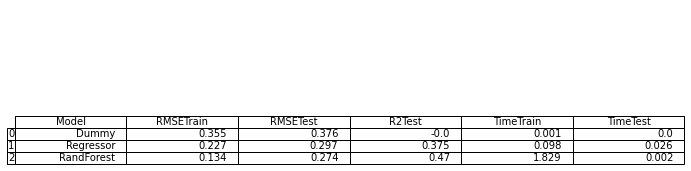

In [16]:
#Tableau des résultats des modèles
resultsE = pd.DataFrame()
resultsE=resultsE.assign(Model = ['Dummy', 'Regressor','RandForest'])
resultsE=resultsE.assign(RMSETrain = [rmseDumETrain, rmseRegETrain,rmseRfgETrain])
resultsE=resultsE.assign(RMSETest = [rmseDumE, rmseRegE,rmseRfgE])
resultsE=resultsE.assign(R2Test = [r2DumE, r2RegE,r2RfgE])
resultsE=resultsE.assign(TimeTrain = [timeTrDumE, timeTrRegE,timeTrRfgE])
resultsE=resultsE.assign(TimeTest = [timeDumE, timeRegE,timeRfgE])

print(resultsE)
# Affichage sous forme de tableau à télécharger
plt.figure(figsize=(12,2))
plt.tight_layout()
# Pas d'axes
ax = plt.subplot(111, frame_on=False)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
#Création du tableau
from pandas.plotting import table
table(ax, resultsE.round(decimals=3))
#Sauvegarde
plt.savefig('resultsE.png', bbox_inches = 'tight')


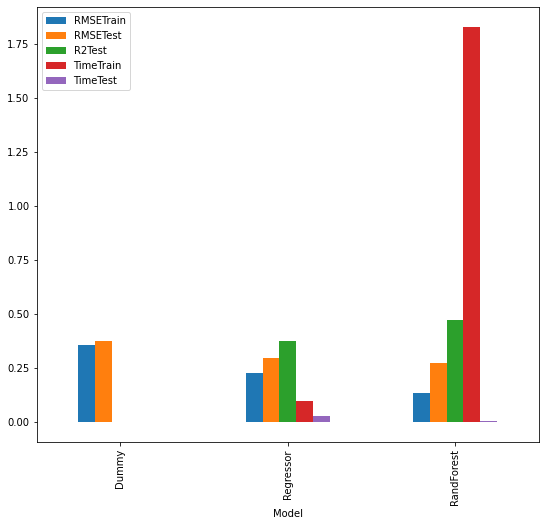

In [17]:
#Barplot associé
resultsE.plot(x="Model", y=["RMSETrain", "RMSETest", "R2Test","TimeTrain", "TimeTest"], kind="bar",figsize=(9,8))
#Sauvegarde
plt.savefig('resultsEBarplot.png', bbox_inches = 'tight')

### Choix du modèle

Première constatation, le temps de prédiction reste très faible dans chaque modèle, probablement du fait du faible nombre d'observations. Le predicteur par forêt aléatoire apporte un meilleur RMSE (0.274 contre 0.297) on va donc le retenir pour la prédiction.
Le score de 0.274 peut paraître faible et il est probablement plus précis de prédire la consommation totale, en effet, car la surface totale permettrait d'ajouter beaucoup de précision à un modèle de calcul de la conso totale. Néammoins, je crois que la finalité de calculer la consommation surfaçique et la multiplier avec la consommation surfaçique estimée donnera une précision globale supérieure. Dis différemment, la trop forte corrélation entre la surface et la consommation risque d'entrainer une éviction arbitraire de variables qu'il est plus pertinent de laisser au machine learning, là où la surface peut-être ajoutée à la prédiction à postériori par une simple multiplication.

La différence entre RMSE à l'entraînement et au test révèle que la regression ne présente aucun overfitting contrairement à la prédiction par random forest qui overfit un peu. Cela n'est pas étonnant vu la nature de ces deux algorithmes



In [18]:
#Impact des variables
featImpactE = pd.DataFrame()
featImpactE['Impact']=rfgE.feature_importances_
featImpactE['Feature']=data.columns[:-3] #Nom des variables
featImpactE.sort_values('Impact', ascending=True, inplace=True)

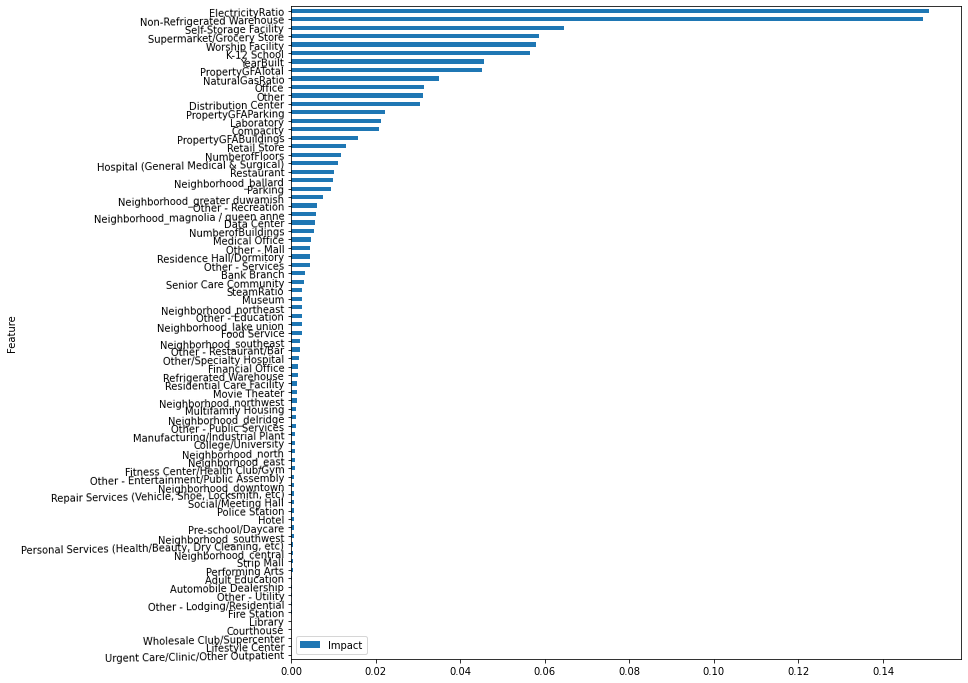

In [19]:
#Graphique Impact des variables
ax = featImpactE.plot.barh(x='Feature', y='Impact', rot=1,figsize=(12,12))
#Sauvegarde
plt.savefig('impactE.png', bbox_inches = 'tight')

Commentaires sur l'importance des variables :

Electrity ratio, YearBuilt : même commentaires qu'à l'analyse exploratoire

Warehouse, self-storage : un usage assez répandu et qui donne généralement des consommations surfaçiques particulièrement faibles d'où un impact important dans la prédiction, idem pour l'usage de Parking

Compacity vs PropertyGFABuildings : la compacité semble apporter plus d'information que la surface de bâtiments, cela suffit-il à dire que le feature engineering était justifié ?


# Limitation du nombre de variables et fine tuning
On réduit le nombre de variables en excluant celles qui ont le moins d'impact (- de 0.5%)

In [20]:
#Sélection des variables à conserver
featReducE = featImpactE.query('Impact>=0.005')
featReducE.shape

(27, 2)

In [21]:
#Définition des X et y
X = data[featReducE['Feature'].to_list()].values
y = data['SiteEUIkBtusf.log10'].values

# Séparation des set Train et Test
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=42)

In [22]:
# Estimateur Random Forest Gradient Boosting optimal
rfgE = ensemble.GradientBoostingRegressor(loss='huber',max_depth=4, learning_rate=0.1, n_estimators=250, random_state=42)

# Entrainement
rfgE.fit(X_train, y_train)

# Prédiction
start = time() 
y_pred_rfgE = rfgE.predict(X_test)
end = time()
timeRfgE = end - start

#Prédiction sur le training set
y_pred_rfgE_train = rfgE.predict(X_train)
rmseRfgETrain = np.sqrt(metrics.mean_squared_error(y_train, y_pred_rfgE_train))
print("RMSE Train : {:.3f}".format(rmseRfgETrain))

# Calcul des métriques d'évaluation
rmseRfgE = np.sqrt(metrics.mean_squared_error(y_test, y_pred_rfgE))
print("RMSE: {:.3f}".format(rmseRfgE))
r2RfgE = metrics.r2_score(y_test, y_pred_rfgE)
print("R2: {:.5f}".format(r2RfgE))
print("Time: {:.2f}".format(timeRfgE))

RMSE Train : 0.123
RMSE: 0.278
R2: 0.45297
Time: 0.00


L'erreur n'est presque pas modifiée. On peut maintenant essayer d'ajuster les hyperparamètres.

In [23]:
start = time()

# Paramètres à tester sur la GridSearch avec validation croisée
# Pour recalculer en entier le notebook plus rapidement, certains paramètres ont été écartés à posteriori
paramGrid = {'loss':['huber']}#, 'learning_rate':[10**-1.5,0.1,10**-0.5] ,  'n_estimators':[200,250,300], 'random_state':[42] }
#paramGrid = {'loss':['ls', 'lad', 'huber']}
target = 'neg_root_mean_squared_error'

# Recherche d'hyperparamètre par validation croisée
rfg = model_selection.GridSearchCV(ensemble.GradientBoostingRegressor(), paramGrid, cv=5, scoring=target)

# Entrainement
rfg.fit(X_train, y_train)

# Meilleurs paramètres
print(rfg.best_params_)

# Afficher les performances correspondantes
print("Résultats de la validation croisée :")
for mean, std, params in zip(rfg.cv_results_['mean_test_score'], rfg.cv_results_['std_test_score'],  rfg.cv_results_['params']):
    print("{} = {:.3f} (+/-{:.03f}) for {}".format(target,mean,std,params))

end = time()
print(end - start)

{'loss': 'huber'}
Résultats de la validation croisée :
neg_root_mean_squared_error = -0.258 (+/-0.016) for {'loss': 'huber'}
2.624185800552368


Aucun changement d'hyperparamètres à prévoir. Les hyperparamètres optimaux sont inchangés.

# Utilité de l'ENERGYSTARSCore

In [24]:
# Création d'un dataframe sans les bâtiment à ENERGYSTARScore inconnu
data2 = data.query('ENERGYSTARScore==ENERGYSTARScore')

# Variables à utiliser
featListE=featReducE['Feature'].to_list()
featListE.append('ENERGYSTARScore')

#Séparation des jeux de données train et test
X = data2[featListE].values
y = data2['SiteEUIkBtusf.log10'].values

from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=42)

In [25]:
# Estimateur Random Forest Gradient Boosting optimal
rfgE = ensemble.GradientBoostingRegressor(loss='huber',max_depth=4, learning_rate=0.1, n_estimators=250, random_state=42)

# Entrainement
start = time()
rfgE.fit(X_train, y_train)
end = time()
timeTrRfgEES = end - start

# Prédiction
start = time() 
y_pred_rfgE = rfgE.predict(X_test)
end = time()

#Prédiction sur le training set
y_pred_rfgE_train = rfgE.predict(X_train)
rmseRfgETrainES = np.sqrt(metrics.mean_squared_error(y_train, y_pred_rfgE_train))
print("RMSE Train : {:.3f}".format(rmseRfgETrainES))

# Calcul des métriques d'évaluation
rmseRfgEES = np.sqrt(metrics.mean_squared_error(y_test, y_pred_rfgE))
print("RMSE: {:.3f}".format(rmseRfgEES))
r2RfgEES = metrics.r2_score(y_test, y_pred_rfgE)
print("R2: {:.5f}".format(r2RfgEES))
timeRfgEES = end - start
print("Time: {:.2f}".format(timeRfgEES))

RMSE Train : 0.048
RMSE: 0.148
R2: 0.75744
Time: 0.00


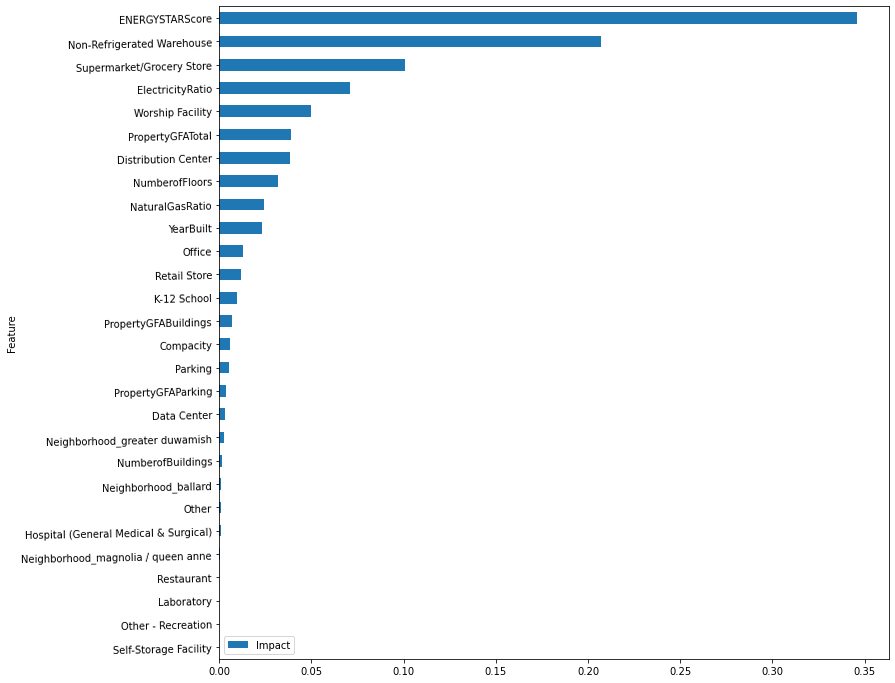

In [27]:
#Impact des variables
featImpactEES = pd.DataFrame()
featImpactEES['Impact']=rfgE.feature_importances_
featImpactEES['Feature']=featListE
featImpactEES.sort_values('Impact', ascending=True, inplace=True)
# Graphique Impact des variables
ax = featImpactEES.plot.barh(x='Feature', y='Impact', rot=1,figsize=(12,12))
#Sauvegarde
plt.savefig('impactEES.png', bbox_inches = 'tight')

Avec une RMSE de 0.148 contre 0.274, l'ajout de l'ENERGYSTARScore permet à la prédiction de la consommation surfaçique d'être nettement plus performante. De plus, on observe que c'est de loin la variable la plus importante dans la prédiction.

# Prédiction de l'émission de GHG surfaçique GHGEmissionsIntensity

In [28]:
#Définition des données X et y
X = data[data.columns[:-3]].values
y = data['GHGEmissionsIntensity.log10'].values

#Séparation des jeux de données train et test
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=42) # 30% des données dans le jeu de tes

### Dummy regressor

In [29]:
# Regression naïve par la moyenne
dumG = dummy.DummyRegressor(strategy='mean')

# Entraînement
start = time() 
dumG.fit(X_train, y_train)
end = time()
timeTrDumG = end - start

# Prédiction sur le jeu de test avec temps de calcul
start = time()
y_pred_dumG = dumG.predict(X_test)
end = time()
timeDumG = end - start

#Prédiction sur le training set
y_pred_DumG_train = dumG.predict(X_train)
rmseDumGTrain = np.sqrt(metrics.mean_squared_error(y_train, y_pred_DumG_train))
print("RMSE Train : {:.3f}".format(rmseDumGTrain))

# Calcul des métriques d'évaluation
rmseDumG = np.sqrt(metrics.mean_squared_error(y_test, y_pred_dumG))
print("RMSE: {:.2f}".format(rmseDumG))
r2DumG = metrics.r2_score(y_test, y_pred_dumG)
print("R2: {:.5f}".format(r2DumG))
print("Time: {:.2f}".format(timeDumG))               
print("TrainingTime: {:.2f}".format(timeTrDumG))  

RMSE Train : 0.211
RMSE: 0.21
R2: -0.00008
Time: 0.00
TrainingTime: 0.00


### Regression rigde

In [30]:
# Paramètres à tester sur la GridSearch avec validation croisée
# Pour recalculer en entier le notebook plus rapidement, certains paramètres ont été écartés à posteriori
paramGrid = {'kernel':['rbf']}#, 'linear', 'poly'],'alpha': [1e0, 0.1, 1e-2, 1e-3],'gamma': np.logspace(-2, 2, 5)}
target = 'neg_root_mean_squared_error'

# Recherche d'hyperparamètre par validation croisée
reg = model_selection.GridSearchCV(kernel_ridge.KernelRidge(), paramGrid, cv=5, scoring=target)

# Entrainement
reg.fit(X_train, y_train)

# Meilleurs paramètres
print(reg.best_params_)

# Afficher les performances correspondantes
print("Résultats de la validation croisée :")
for mean, std, params in zip(reg.cv_results_['mean_test_score'], reg.cv_results_['std_test_score'],  reg.cv_results_['params']):
    print("{} = {:.3f} (+/-{:.03f}) for {}".format(target,mean,std,params))

{'kernel': 'rbf'}
Résultats de la validation croisée :
neg_root_mean_squared_error = -0.146 (+/-0.011) for {'kernel': 'rbf'}


In [31]:
# Estimateur KernelRidge optimal
regressorG = kernel_ridge.KernelRidge(alpha= 1, gamma= 0.01, kernel= 'linear')

# Entrainement
start = time() 
regressorG.fit(X_train, y_train)
end = time()
timeTrRegG = end - start

# Prédiction
start = time() 
y_pred_regG = regressorG.predict(X_test)
end = time()
timeRegG = end - start

#Prédiction sur le training set
y_pred_regG_train = regressorG.predict(X_train)
rmseRegGTrain = np.sqrt(metrics.mean_squared_error(y_train, y_pred_regG_train))
print("RMSE Train : {:.3f}".format(rmseRegGTrain))


# Calcul des métriques d'évaluation
rmseRegG = np.sqrt(metrics.mean_squared_error(y_test, y_pred_regG))
print("RMSE: {:.2f}".format(rmseDumG))
r2RegG = metrics.r2_score(y_test, y_pred_regG)
print("R2: {:.5f}".format(r2RegG))
print("Time: {:.2f}".format(timeRegG))
print("TrainingTime: {:.2f}".format(timeTrRegG))

RMSE Train : 0.112
RMSE: 0.21
R2: 0.66346
Time: 0.01
TrainingTime: 0.06


### Random Forest avec Gradient boosting

In [32]:
start = time()

# Paramètres à tester sur la GridSearch avec validation croisée
# Pour recalculer en entier le notebook plus rapidement, certains paramètres ont été écartés à posteriori
paramGrid = {'loss':['huber']}#,'max_depth': [3, 4, 5], 'learning_rate':[0.1,0.2,0.3] ,  'n_estimators':[100,250,500], 'random_state':[42] }
#paramGrid = {'loss':['ls', 'lad', 'huber']}
target = 'neg_root_mean_squared_error'

# Recherche d'hyperparamètre par validation croisée
rfg = model_selection.GridSearchCV(ensemble.GradientBoostingRegressor(), paramGrid, cv=5, scoring=target)

# Entrainement
rfg.fit(X_train, y_train)

# Meilleurs paramètres
print(rfg.best_params_)

# Afficher les performances correspondantes
print("Résultats de la validation croisée :")
for mean, std, params in zip(rfg.cv_results_['mean_test_score'], rfg.cv_results_['std_test_score'],  rfg.cv_results_['params']):
    print("{} = {:.3f} (+/-{:.03f}) for {}".format(target,mean,std,params))
    
    
end = time()
print(end - start)

{'loss': 'huber'}
Résultats de la validation croisée :
neg_root_mean_squared_error = -0.123 (+/-0.006) for {'loss': 'huber'}
3.0926971435546875


In [33]:
# Estimateur Random Forest Gradient Boosting optimal
rfgG = ensemble.GradientBoostingRegressor(loss='huber',max_depth=3, learning_rate=0.1, n_estimators=100, random_state=42)

# Entrainement
start = time() 
rfgG.fit(X_train, y_train)
end = time()
timeTrRfgG = end - start

# Prédiction
start = time() 
y_pred_rfgG = rfgG.predict(X_test)
end = time()
timeRfgG = end - start

#Prédiction sur le training set
y_pred_rfgG_train = rfgG.predict(X_train)
rmseRfgGTrain = np.sqrt(metrics.mean_squared_error(y_train, y_pred_rfgG_train))
print("RMSE Train : {:.3f}".format(rmseRfgGTrain))

# Calcul des métriques d'évaluation
rmseRfgG = np.sqrt(metrics.mean_squared_error(y_test, y_pred_rfgG))
print("RMSE: {:.3f}".format(rmseRfgG))
r2RfgG = metrics.r2_score(y_test, y_pred_rfgG)
print("R2: {:.5f}".format(r2RfgG))
print("Time: {:.2f}".format(timeRfgG))
print("TrainingTime: {:.2f}".format(timeTrRfgG))

RMSE Train : 0.095
RMSE: 0.12
R2: 0.66241
Time: 0.00
TrainingTime: 0.57


        Model  RMSETrain  RMSETest    R2Test  TimeTrain  TimeTest
0       Dummy   0.210577  0.211555 -0.000079   0.000445  0.000314
1   Regressor   0.111720  0.122723  0.663459   0.060918  0.009350
2  RandForest   0.095416  0.122915  0.662405   0.571495  0.001288


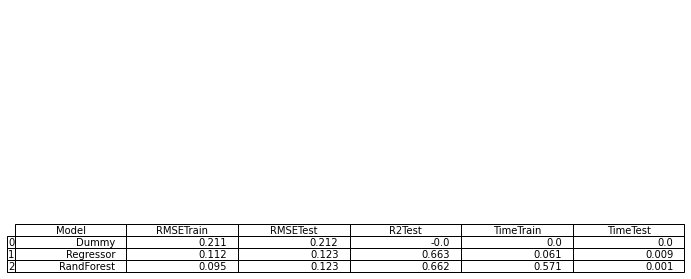

In [34]:
#Tableau des résultats des modèles
resultsG = pd.DataFrame()
resultsG =resultsG.assign(Model = ['Dummy', 'Regressor','RandForest'])
resultsG =resultsG.assign(RMSETrain = [rmseDumGTrain, rmseRegGTrain,rmseRfgGTrain])
resultsG =resultsG.assign(RMSETest = [rmseDumG, rmseRegG,rmseRfgG])
resultsG =resultsG.assign(R2Test = [r2DumG, r2RegG,r2RfgG])
resultsG =resultsG.assign(TimeTrain = [timeTrDumG, timeTrRegG,timeTrRfgG])
resultsG =resultsG.assign(TimeTest = [timeDumG, timeRegG,timeRfgG])

print(resultsG)
# Affichage sous forme de tableau à télécharger
plt.figure(figsize=(12,4))
plt.tight_layout()
# Pas d'axes
ax = plt.subplot(111, frame_on=False)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
#Création du tableau
table(ax, resultsG.round(decimals=3))
#Sauvegarde
plt.savefig('resultsG.png', bbox_inches = 'tight')


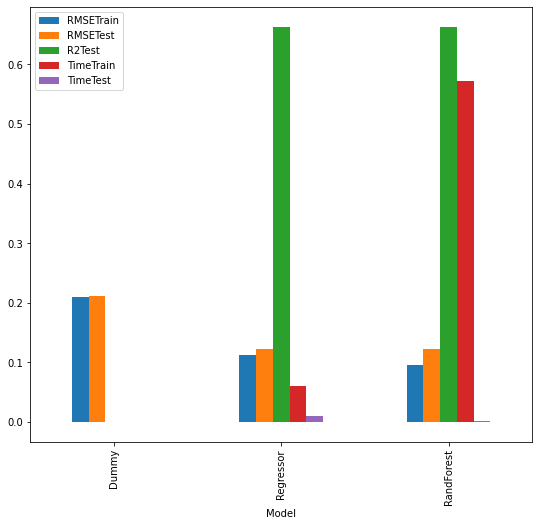

In [35]:
#Barplot associé
resultsG.plot(x="Model", y=["RMSETrain", "RMSETest", "R2Test","TimeTrain", "TimeTest"], kind="bar",figsize=(9,8))
#Sauvegarde
plt.savefig('resultsGBarplot.png', bbox_inches = 'tight')

Première constatation, le temps de prédiction reste très faible dans chaque modèle, probablement du fait du faible nombre d'observations. Les deux algorithmes apportent des résultats quasi-équivalents, la regression sur-apprends moins (RMSE entraînement et test très proches) Cependant, à des fins d'étude, je vais privilégier la Random Forest pour pouvoir calculer l'impact des variables.

In [36]:
#Impact des variables
featImpactG = pd.DataFrame()
featImpactG['Impact']=rfgG.feature_importances_
featImpactG['Feature']=data.columns[:-3]
featImpactG.sort_values('Impact', ascending=True, inplace=True)

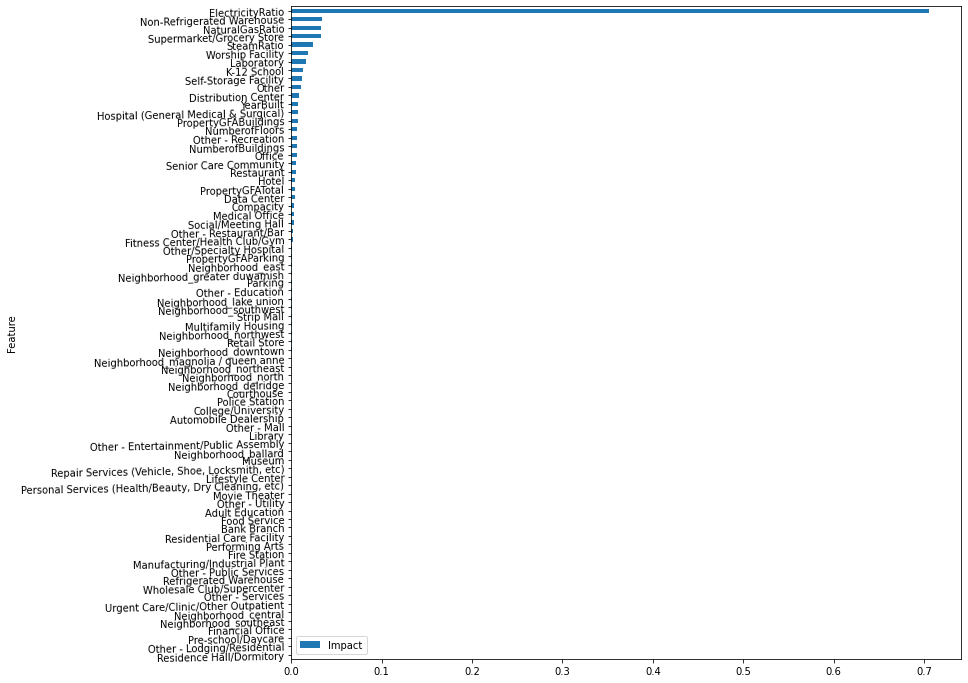

In [37]:
# Graphique Impact des variables
ax = featImpactG.plot.barh(x='Feature', y='Impact', rot=1,figsize=(12,12))
#Sauvegarde
plt.savefig('impactG.png', bbox_inches = 'tight')

La détermination de l'intensité des émissions de GHG est principalement liée au ratio d'usage de l'électricité. Cela s'explique très bien par le fait que le calcul des émissions GHG est effectué sur la quantité d'énergie consommée selon l'énergie utilisée. La meilleure manière de calculer les émissions est donc d'utiliser les ratios d'usage et l'estimation de consommation calculée par notre précédent problème. Etant donné que l'énergie consommée et les émissions sont mathématiquement liés, il faut comprendre que le problème de l'énoncé est mal posé ou plutôt peut-être posé différemment : la détermination de la consommation surfaçique devrait être notre objectif premier, surtout à partir du moment où les ratios d'utilisation de l'énergie peuvent être estimés par avance (ce qui est généralement le cas).

# Limitation du nombre de variables et fine tuning
On réduit le nombre de variables en excluant celles qui ont le moins d'impact (- de 0.2%)

In [38]:
#Variables à conserver
featReducG = featImpactG.query('Impact>=0.002')
featReducG.shape

(26, 2)

In [39]:
#Définition des données X et y
X = data[featReducG['Feature'].to_list()].values
y = data['GHGEmissionsIntensity.log10'].values

#Séparation des jeux de données train et test
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=42)

In [40]:
# Estimateur Random Forest Gradient Boosting optimal
rfgG = ensemble.GradientBoostingRegressor(loss='huber',max_depth=3, learning_rate=0.1, n_estimators=100, random_state=42)

# Entrainement
rfgG.fit(X_train, y_train)

# Prédiction
start = time() 
y_pred_rfgG = rfgG.predict(X_test)
end = time()

#Prédiction sur le training set
y_pred_rfgG_train = rfgG.predict(X_train)
rmseRfgGTrain = np.sqrt(metrics.mean_squared_error(y_train, y_pred_rfgG_train))
print("RMSE Train : {:.3f}".format(rmseRfgGTrain))

# Calcul des métriques d'évaluation
rmseRfgG = np.sqrt(metrics.mean_squared_error(y_test, y_pred_rfgG))
print("RMSE: {:.3f}".format(rmseRfgG))
r2RfgG = metrics.r2_score(y_test, y_pred_rfgG)
print("R2: {:.5f}".format(r2RfgG))
timeRfgG = end - start
print("Time: {:.2f}".format(timeRfgG))

RMSE Train : 0.096
RMSE: 0.12
R2: 0.66697
Time: 0.00


L'erreur n'est presque pas modifiée. On peut maintenant essayer d'ajuster les hyperparamètres.

In [41]:
start = time()

# Paramètres à tester sur la Gridsearch avec validation croisée
# Pour recalculer en entier le notebook plus rapidement, certains paramètres ont été écartés à posteriori
paramGrid = {'loss':['huber']}#, 'learning_rate':[10**-1.5,0.1,10**-0.5] ,  'n_estimators':[50,100,150], 'random_state':[42] }
#paramGrid = {'loss':['ls', 'lad', 'huber']}
target = 'neg_root_mean_squared_error'

# Recherche d'hyperparamètre par validation croisée
rfg = model_selection.GridSearchCV(ensemble.GradientBoostingRegressor(), paramGrid, cv=5, scoring=target)

# Entrainement
rfg.fit(X_train, y_train)

# Meilleurs paramètres
print(rfg.best_params_)

# Afficher les performances correspondantes
print("Résultats de la validation croisée :")
for mean, std, params in zip(rfg.cv_results_['mean_test_score'], rfg.cv_results_['std_test_score'],  rfg.cv_results_['params']):
    print("{} = {:.3f} (+/-{:.03f}) for {}".format(target,mean,std,params))

end = time()
print(end - start)

{'loss': 'huber'}
Résultats de la validation croisée :
neg_root_mean_squared_error = -0.121 (+/-0.006) for {'loss': 'huber'}
2.512944221496582


La nouvelle GridSearch a permis d'affiner les hyper-paramètres, nombre d'estimateurs est relevé à 150.

In [42]:
# Estimateur Random Forest Gradient Boosting optimal
rfgG = ensemble.GradientBoostingRegressor(loss='huber',max_depth=3, learning_rate=0.1, n_estimators=150, random_state=42)

# Entrainement
rfgG.fit(X_train, y_train)

# Prédiction
start = time() 
y_pred_rfgG = rfgG.predict(X_test)
end = time()

#Prédiction sur le training set
y_pred_rfgG_train = rfgG.predict(X_train)
rmseRfgGTrain = np.sqrt(metrics.mean_squared_error(y_train, y_pred_rfgG_train))
print("RMSE Train : {:.3f}".format(rmseRfgGTrain))

# Calcul des métriques d'évaluation
rmseRfgG = np.sqrt(metrics.mean_squared_error(y_test, y_pred_rfgG))
print("RMSE: {:.2f}".format(rmseRfgG))
r2RfgG = metrics.r2_score(y_test, y_pred_rfgG)
print("R2: {:.5f}".format(r2RfgG))
timeRfgG = end - start
print("Time: {:.2f}".format(timeRfgG))

RMSE Train : 0.089
RMSE: 0.12
R2: 0.67280
Time: 0.00


# Utilité de l'ENERGYSTARSCore

In [43]:
# Variables à utiliser
featListG=featReducG['Feature'].to_list()
featListG.append('ENERGYSTARScore')

# Définition des données X et y
X = data2[featListG].values
y = data2['GHGEmissionsIntensity.log10'].values

#Séparation des jeux de données train et test
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=42)

In [44]:
# Estimateur Random Forest Gradient Boosting optimal
rfgG = ensemble.GradientBoostingRegressor(loss='huber',max_depth=3, learning_rate=0.1, n_estimators=150, random_state=42)

# Entrainement
start = time() 
rfgG.fit(X_train, y_train)
end = time()
timeTrRfgGES = end - start

# Prédiction
start = time() 
y_pred_rfgG = rfgG.predict(X_test)
end = time()

#Prédiction sur le training set
y_pred_rfgG_train = rfgG.predict(X_train)
rmseRfgGTrainES = np.sqrt(metrics.mean_squared_error(y_train, y_pred_rfgG_train))
print("RMSE Train : {:.3f}".format(rmseRfgGTrainES))

# Calcul des métriques d'évaluation
rmseRfgGES = np.sqrt(metrics.mean_squared_error(y_test, y_pred_rfgG))
print("RMSE: {:.2f}".format(rmseRfgGES))
r2RfgGES = metrics.r2_score(y_test, y_pred_rfgG)
print("R2: {:.5f}".format(r2RfgGES))
timeRfgGES = end - start
print("Time: {:.2f}".format(timeRfgGES))

RMSE Train : 0.044
RMSE: 0.08
R2: 0.83006
Time: 0.00


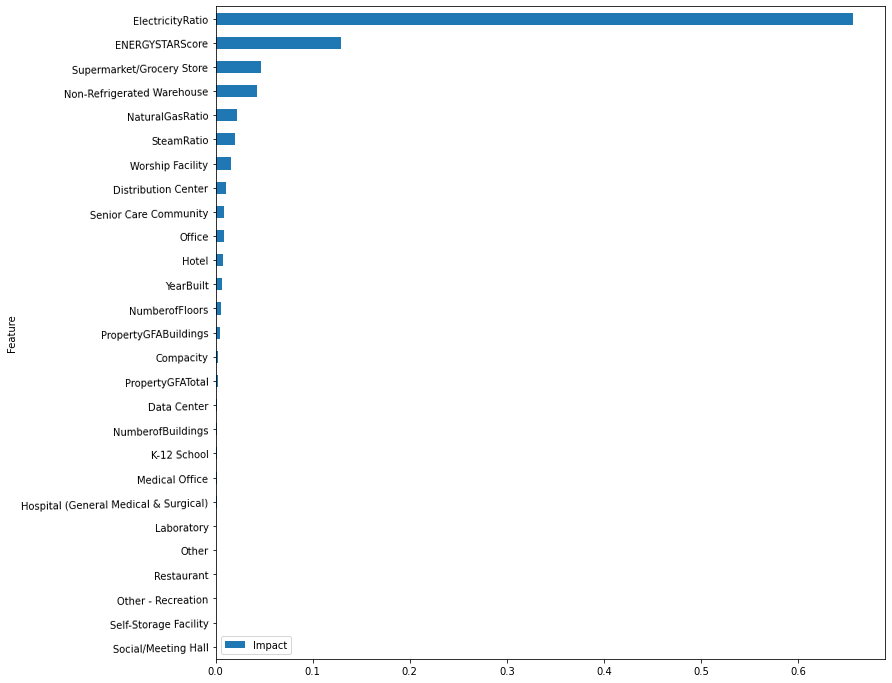

In [47]:
#Impact des variables
featImpactGES = pd.DataFrame()
featImpactGES['Impact']=rfgG.feature_importances_
featImpactGES['Feature']=featListG
featImpactGES.sort_values('Impact', ascending=True, inplace=True)
# Graphique Impact des variables
ax = featImpactGES.plot.barh(x='Feature', y='Impact', rot=1,figsize=(12,12))
#Sauvegarde
plt.savefig('impactGES.png', bbox_inches = 'tight')

Avec une RMSE de 0.08 contre 0.12, l'ajout de l'ENERGYSTARScore permet à la prédiction de la consommation surfaçique d'être plus performante. L'ENERGYSTARScore ne semble pas avoir la même importance que dans la prédiction de la consommation énergétique, ce n'est pas abhérrant, après tout, il est calculé pour représenter une qualité énergétique. Le score se place quand même comme la 2e variable la plus importante.

                  Model  RMSETrain  RMSETest    R2Test  TimeTrain  TimeTest
0                Energy   0.122884  0.278031  0.452972   1.828699  0.002646
1     Energy + ES Score   0.047538  0.147670  0.757444   1.372338  0.002302
2             Emissions   0.088880  0.121008  0.672796   0.571495  0.001502
3  Emissions + ES Score   0.044438  0.083579  0.830062   0.551744  0.001350


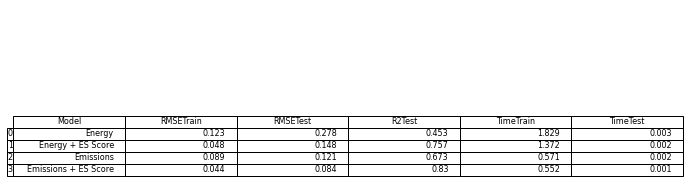

In [45]:
#Tableau des résultats des modèles optimisés avec et sans EnergyStarScore pour l'énergie et les émissions
resultsEStar = pd.DataFrame()
resultsEStar =resultsEStar.assign(Model = ['Energy', 'Energy + ES Score','Emissions','Emissions + ES Score'])
resultsEStar =resultsEStar.assign(RMSETrain = [rmseRfgETrain,rmseRfgETrainES,rmseRfgGTrain,rmseRfgGTrainES])
resultsEStar =resultsEStar.assign(RMSETest = [rmseRfgE,rmseRfgEES,rmseRfgG,rmseRfgGES,])
resultsEStar =resultsEStar.assign(R2Test = [r2RfgE,r2RfgEES,r2RfgG,r2RfgGES])
resultsEStar =resultsEStar.assign(TimeTrain = [timeTrRfgE,timeTrRfgEES,timeTrRfgG,timeTrRfgGES])
resultsEStar =resultsEStar.assign(TimeTest = [timeRfgE,timeRfgEES,timeRfgG,timeRfgGES])

print(resultsEStar)
# Affichage sous forme de tableau à télécharger
plt.figure(figsize=(12,2))
plt.tight_layout()
# Pas d'axes
ax = plt.subplot(111, frame_on=False)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
#Création du tableau
table(ax, resultsEStar.round(decimals=3))
#Sauvegarde
plt.savefig('resultsEStar.png', bbox_inches = 'tight')

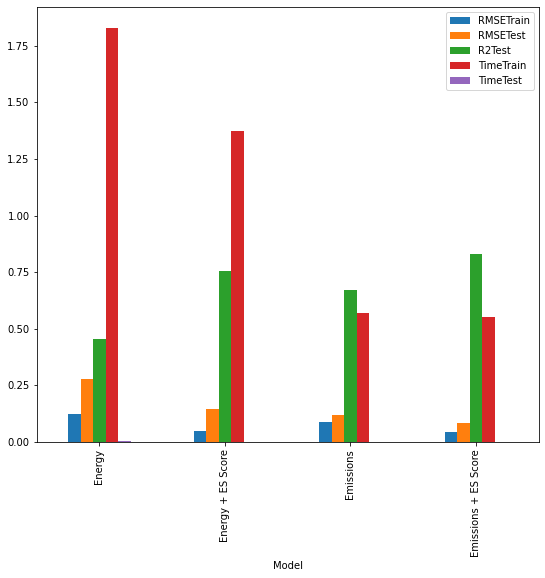

In [50]:
#Barplot associé
resultsEStar.plot(x="Model", y=["RMSETrain", "RMSETest", "R2Test","TimeTrain", "TimeTest"], kind="bar",figsize=(9,8))
#Sauvegarde
plt.savefig('resultsEStarBarplot.png', bbox_inches = 'tight')

# Conclusion et réflexions

Les deux modèles testés obtiennent de bonne performances sur les deux prédictions avec néanmmoins une performance plus élevée sur la prédiction des émissions GHG. On observe que la pertinence de l'ENERGYSTARScore est validée par les algorithmes de machine learning qui montrent des performances nettement plus élevées quand cette variable est disponible.

Pour aller plus loin, plusieurs points peuvent être étudiés :

- L'année de construction ja été traité comme une variable quantitative pour refléter l'evolution constante des techniques de construction censées s'améliorer avec le temps mais l'âge d'un bâtiment peu aussi refléter des usages différents, des prestations différentes. On aurait donc également pu considérer cette variable comme qualitative en répartissant les bâtiments en différentes époques (par décénnie ou après une classification non supervisée)

- Le ratio d'énergie pourrait être remplacé par une information plus facile à obtenir : la présence de sources d'énergie par usage énergétique spécifique (chauffage, ECS, process, etc...)

- Une information sur les capacités de production d'énergie du lot (panneaux photovoltaiques ou thermiques)

- Une réflexion plus large autour des données facilement accessibles sur ces bâtiments

- Les usages sont très nombreux et certains trop rares sont peu pris en compte dans les modèles, on pourrait esdsayer de les grouper au préalable avec une réduction de dimension ou une classification non supervisée.


